# Introduction

With coronavirus and quarantine, companies in at-home fitness like Peloton experienced explosive growth. I was one of these people who invested in a Peloton bike and became a part of their online community. A common post is expression of excitement for their bike delivery coming soon and asking the group:  **“What class and/or instructor should I take first?”**

A big part in selecting classes comes down to perceived difficulty based on the user. There isn’t a UI feature to filter by this, but at a class level you can see the difficulty level based on user ratings they are prompted for after completing a ride. Additionally, there is the capability to search class by a song or artist based on what is on the playlist to pull classes with the type of music the person wants to ride to.

#### This notebook contains the winning Decision Tree model that predicts the perceived difficulty of the class based on Peloton class data including the Spotify features of the artists and tracks from the class playlists. As this was created with those receiving their Peloton bike in mind, the dataset and model only considers Cycling classes.

<br>The goal metric was the F1 score (both micro-averaged and macro-averaged were tested for/considered)** as a False Positive like a class is labeled easy, but it isn't and a False Negative of a class is not labeled easy, but it is are of equal risk. They both impact a riders first experience with the bike. This is especially important for confidence building and creating a routine in fitness. If a class labelled easy is too difficult, the rider will less likely be back as completing the ride was not an achievable outcome.

# Notebook Summary

#### Models

**Initiating**
- [Creating Dataset](#CD)

**Modeling**
- [Manual Preprocessing](#MP)
- [Winning Decision Tree and Viz](#WDT)

**Analysis**
- [Low Impact Rides](#LowIm)
- [Class Duration](#ClassDur)
- [Interval Rides](#Int)
- [Hannah Corbin Rides](#HC)
- [Top Artists and Tracks per Difficulty](#TopAandS)

**Conclusion**
- [Recommendations](#REC)
- [Future Work](#FW)


**Results**

The final Decision Tree resulted in an accuracy and f1 score of 67-69%. From the modeling perspective, this is a net positive result as it is an improvement from the baseline of a 50% accuracy guessing Intermediate difficulty as it is the majority class.

The top features the drove classification were:
- whether a class was a Low Impact ride
- the class duration
- whether the class was an Intervals ride

The Intermediate class has highest f1 and recall scores, which makes sense as Intermediate is the majority class.
- Recall: What proportion of Intermediate classes were identified correctly?

The Beginner class has the highest precision.
- Precision: What proportion of classes the model identified as "Beginner" difficulty were actually correct?

When applied to the business context, it is also positive result as Peloton is introducing cycling and spin to those who were not cyclists before ([Source](https://www.nbcnews.com/better/lifestyle/fitness-brands-mirror-fight-camp-peloton-want-you-quit-gym-ncna1064376)). This would signal that the majority of people's first ride would be in the Beginner or Intermediate space; thus it is acceptable for Advanced class difficulty to not be a labelling priority in comparison.

In [133]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import math

# # Importing dfs with heavy processing
# import pickle

# Imports Modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Decision Tree Plotting
import graphviz
from sklearn import tree
import pylab

In [134]:
# import custom functions, associated packages and pickle files
%run '/Users/amandagaeta/Documents/Flatiron/capstone/project/Peloton-Class-Difficulty-Classification-With-Playlists/data/peloton_spotify_functions.py'

## Creating base dataset<a id="CD"></a>
The steps below get the data to match Data V6 from previous notebooks where instructors and class categories were condensed to account for those with low counts.

In [136]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [137]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [139]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [141]:
# Create numerical target, can use classDifficulty_cat for labels
df['classDifficulty_num'] = df['classDifficulty_cat'].map({'Beginner': 0,
                                                           'Intermediate': 1,
                                                           'Advanced': 2})

In [142]:
# Group instructors will low class count
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')

In [143]:
# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})                                               

## Modeling

In [145]:
# Define X and y 
# Drop Peloton class features not used in model
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classDifficulty_num',
                     'classOriginalAirdate', 'classType', 'classLength', 'instructorBio', 'classEquipment', 
                     'classUrl', 'classRating', 'classRatingCount', 'classDescription', 'classSongs', 
                     'classArtists','className', 'classLocation'])

# Drop target
y = df['classDifficulty_num']

### Manual Preprocessing for Modeling<a id="MP"></a>

Purposefully not in pipeline for easier data access in analysis

In [146]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [147]:
# Copy df for manipulation
scaled_features = df.copy()

In [148]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [149]:
# Copy df for manipulation
ohe_features = df.copy()

In [150]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [151]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine

In [152]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [153]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Other', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Other', 'instructorName_Robin Arzón',
       'instr

In [154]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Winning Decision Tree Model<a id="WDT"></a>

In [155]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_num'], axis=1)
y = preprocessed['classDifficulty_num']

In [156]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [157]:
# Instantiate
tuned_dt_ent = DecisionTreeClassifier(criterion = 'entropy',
                                      max_depth = 9, 
                                      max_features = 14,
                                      min_samples_leaf = 1, 
                                      min_samples_split = 25,
                                      random_state=42)

tuned_dt_ent.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.83      0.54      0.66       426
Intermediate       0.66      0.81      0.73       861
    Advanced       0.67      0.60      0.63       459

    accuracy                           0.69      1746
   macro avg       0.72      0.65      0.67      1746
weighted avg       0.70      0.69      0.68      1746

Train Scores
------------
Accuracy: 0.7196868436127554
F1 Score: 0.7196868436127553
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6890034364261168
F1 Score Mean Cross Val 3-Fold: 0.6849357406915083


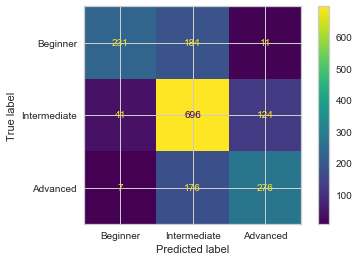

In [158]:
# F1 Micro
eval_model(tuned_dt_ent, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# less overfit by another 1%
# accuracy/f1 only down 0.002

              precision    recall  f1-score   support

    Beginner       0.83      0.54      0.66       426
Intermediate       0.66      0.81      0.73       861
    Advanced       0.67      0.60      0.63       459

    accuracy                           0.69      1746
   macro avg       0.72      0.65      0.67      1746
weighted avg       0.70      0.69      0.68      1746

Train Scores
------------
Accuracy: 0.7196868436127554
F1 Score: 0.7063475753551763
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6719788309487916
F1 Score Mean Cross Val 3-Fold: 0.6707176813375108


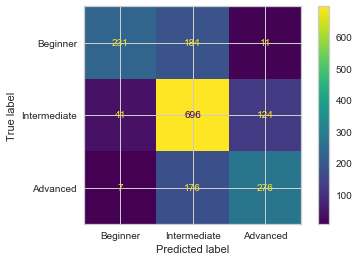

In [159]:
# F1 Macro
eval_model(tuned_dt_ent, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='macro')
# accuracy/f1 down 0.02 from micro

### Visualization

In [160]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

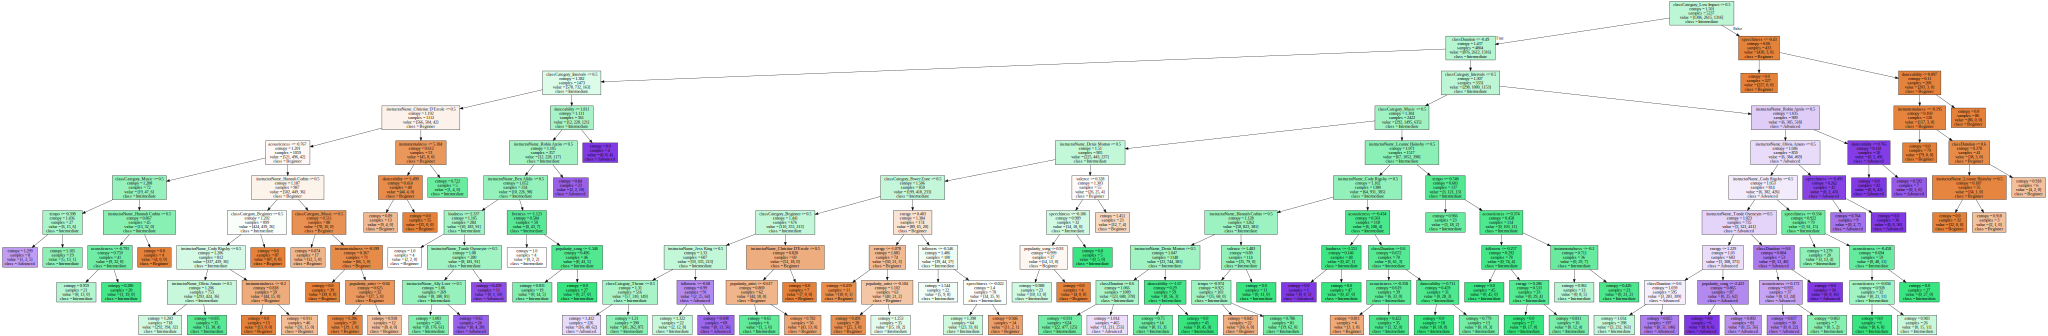

In [161]:
# DOT data
dot_data = tree.export_graphviz(tuned_dt_ent, out_file=None, 
                                feature_names=fn,  
                                class_names=cn,
                                max_depth = 10,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

# save graph
pel_tree = graph.render(filename='../../images/man_pel_tree')

# show graph
graph

# Source:  https://mljar.com/blog/visualize-decision-tree/

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


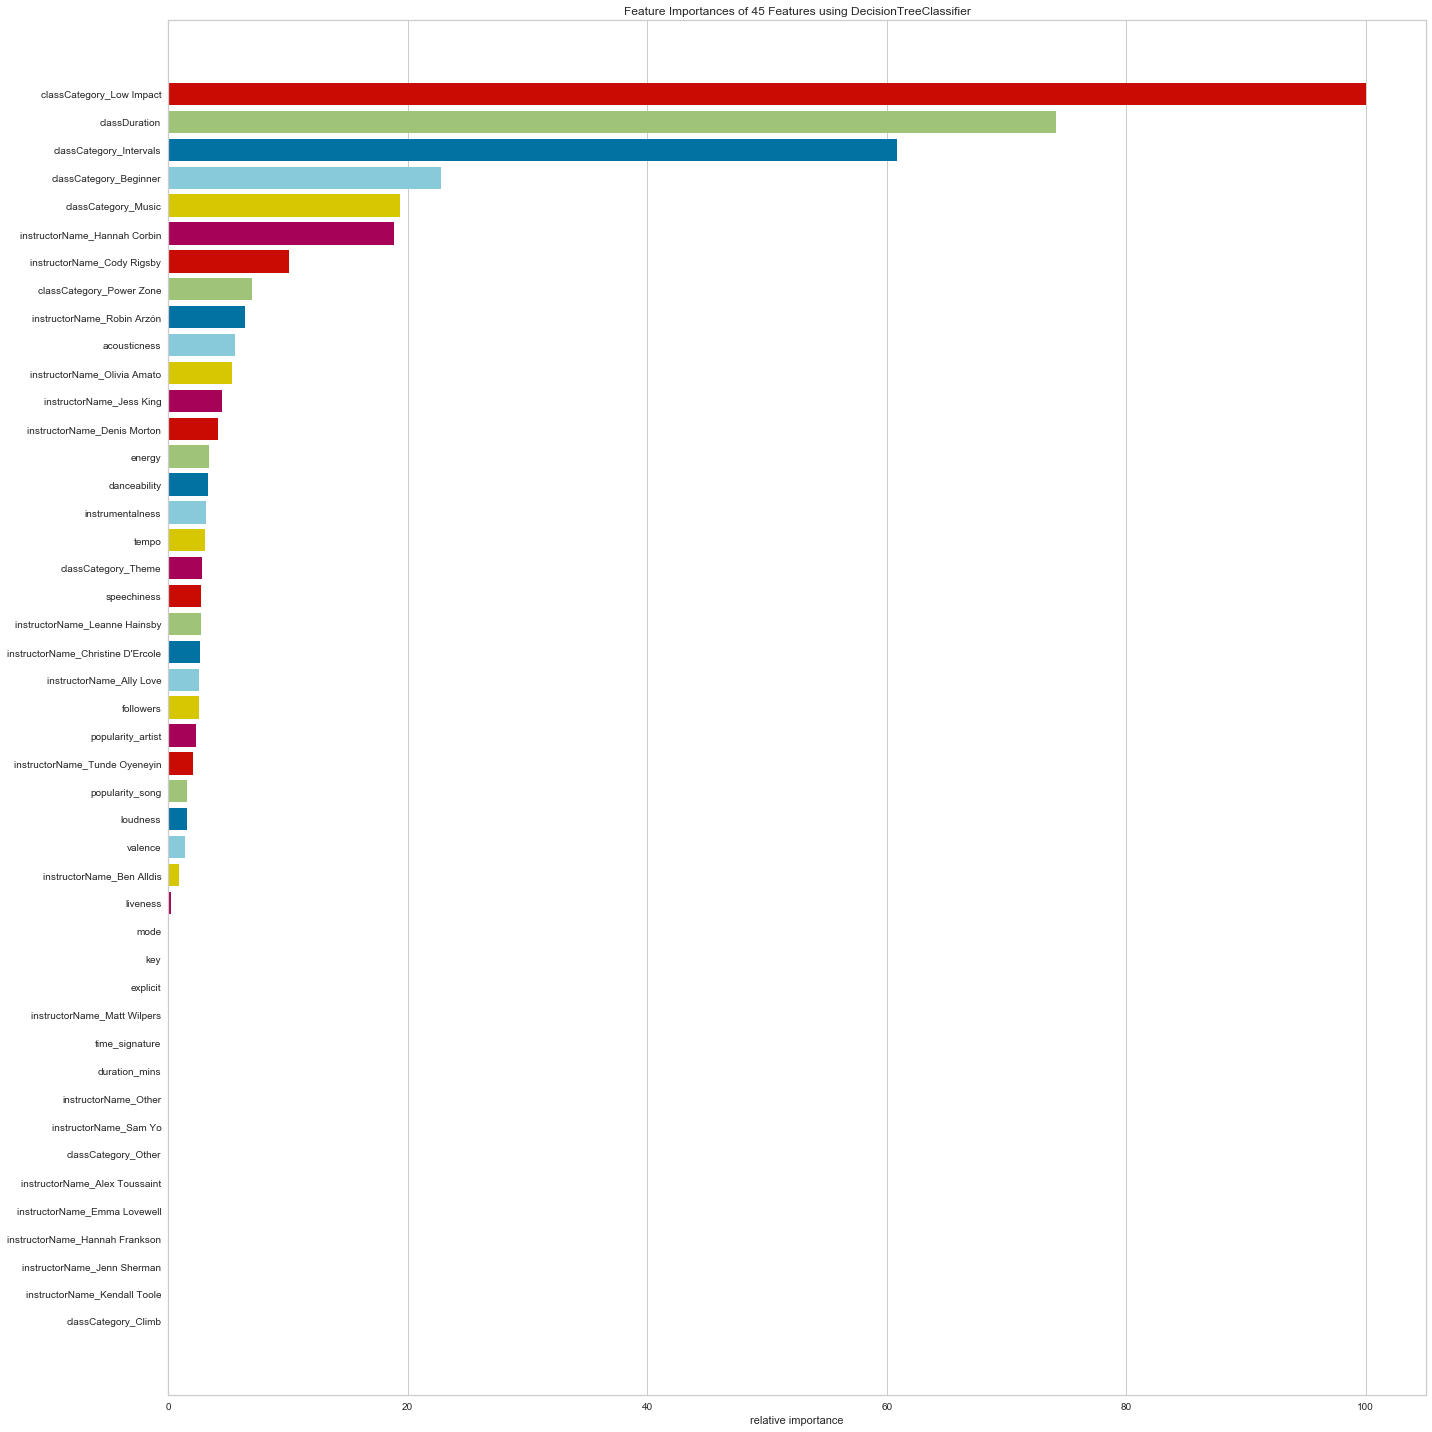

In [162]:
# Feature importance plotting 
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_dt_ent)
viz.fit(X, y)
viz.show()

#### Learning: 
Top drivers of class difficulty level are:
- whether the class is a Low Impact class
- the Class Duration or length of the class
- whether the class is an Intervals class

#### Learnings from tree and analysis below
1. If class is Low Impact, it is Beginner.


2. If a class is Intervals, difficulty will depend on the duration, instructor and/or the music.


3. If the class is < 30 mins it will more likely be Beginner/Intermediate, but could be Intermediate or Advanced if high danceability (> 1.811) and a Robin class. 
    - Next layer towards Beginner class is if Christine is teaching a non-Intervals class < 30 mins. 
        - Her playlists are more instrumental, so the decision below her is instrumentalness <=5.184. If true, Beginner.



4. If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
    - If class is > 30 mins, then still intermediate
    - Is the class an Intervals class? If yes, it will be Advanced
        - Next driver is if instructor is Robin? If yes, then next driver is it the instructor is Olivia? Then Cody, then Tunde. 
        - If not Robin, music danceability <= 0.765 (if TRUE, more likely Advanced -- but Advanced either way)
    - If class is not Intervals, then if classCategory is Music, the class difficulty will lean Intermediate (rare that these classes are Advanced)

## Analysis

### Low Impact<a id="LowIm"></a>

In [244]:
# Filter down dataset to Low Impact rides
preprocessed[preprocessed['classCategory_Low Impact'] == 1]['classDifficulty_num'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# 99.3% of Low Impact rides are Beginner, thus easy for the model to categorize with the majority

0    99.3%
1     0.7%
Name: classDifficulty_num, dtype: object

In [244]:
# Filter down dataset to Low Impact rides
preprocessed[preprocessed['classCategory_Low Impact'] == 1]['classDifficulty_num'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# 99.3% of Low Impact rides are Beginner, thus easy for the model to categorize with the majority

0    99.3%
1     0.7%
Name: classDifficulty_num, dtype: object

### Class Duration <a id="ClassDur"></a>

In [284]:
# Tree split on classDuration <= -0.49. If False, goes to Intervals then Instructors
# Check out if false subset to see what durations fall under this scaled value for Advanced
classdur_subset = preprocessed[preprocessed['classDuration'] > -0.49]

# create variable for original df classDuration Series
og_classdur = df['classDuration']

# Rename for merging
og_classdur.rename('og_classDur', inplace=True)

# Merge original information to subset of scaled classDuration values
ClassDuration_traceback = classdur_subset.merge(og_classdur, how='left', 
                                                left_index=True, right_index=True)

# filter down columns for comparison
only_classdurs = ClassDuration_traceback[['classDuration', 'og_classDur']]

# overview of original classDurations included in subset
only_classdurs['og_classDur'].value_counts()

# Can see classDuration <= -0.49 traces back to classDuration <= 30 minutes

30    2750
45    1740
60     161
90       7
75       6
Name: og_classDur, dtype: int64

In [307]:
# Remove outliers (75 min+ classes, only 13) for charting
class_durations_pie = class_durations_pie[:-2]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  if __name__ == '__main__':


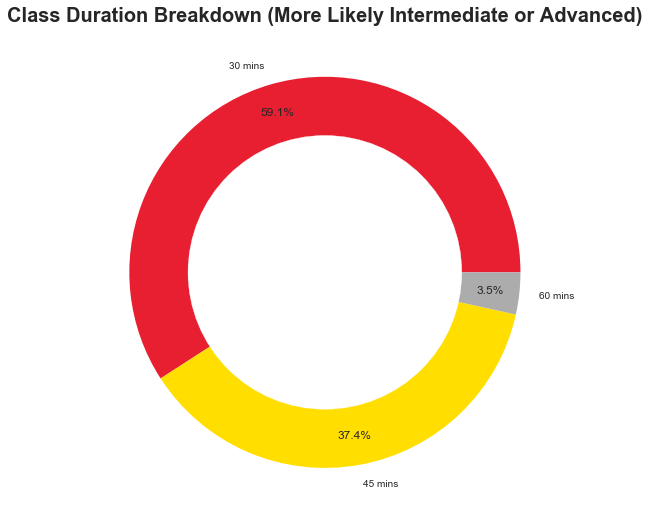

In [356]:
plt.rcParams['font.size'] = 12.0

# Set size
fig = plt.gcf()
fig.set_size_inches(9, 9)

#Create pie chart
plt.pie(class_durations_pie, labels = ['30 mins', '45 mins', '60 mins'],
       labeldistance=1.1, pctdistance=0.85, autopct='%1.1f%%', colors = ['#e71f31','#ffde00','#acacad','#000000'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle) 

plt.title('Class Duration Breakdown (More Likely Intermediate or Advanced)', fontsize=20, fontweight="bold")

# Equal aspect ratio ensures that pie is drawn as a circle
# plt.axis('equal')  
plt.tight_layout()
plt.savefig("../../images/Int_Adv_Class_Duration")
plt.show()

In [174]:
# Compare with all original ClassDurations. Can see all 30 min+ classes are included in the classDuration > -0.49
df['classDuration'].value_counts()

30    2750
20    1749
45    1740
15     318
10     252
60     161
90       7
75       6
Name: og_classDur, dtype: int64

### Intervals<a id="Int"></a>

In [331]:
# Filter down dataset to Interval rides
preprocessed[preprocessed['classCategory_Intervals'] == 1]['classDifficulty_num'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# Most Advanced classes, nearly tied with Intermediate
# Nearly 0 Beginner classes

2    51.0%
1    47.8%
0     1.2%
Name: classDifficulty_num, dtype: object

In [333]:
# Filter down dataset to Interval rides
df[df['classCategory'] == 'Intervals']['instructorName'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# Tree shows that Robin and Olivia Interval classes are more Advanced than other instructors. 
# They make up 11.4% of Intervals classes

Leanne Hainsby        12.5%
Ally Love              9.8%
Ben Alldis             9.1%
Cody Rigsby            7.1%
Hannah Frankson        7.1%
Robin Arzón            6.6%
Sam Yo                 6.4%
Emma Lovewell          6.0%
Alex Toussaint         5.4%
Olivia Amato           4.8%
Tunde Oyeneyin         4.6%
Kendall Toole          4.3%
Jess King              3.7%
Hannah Corbin          3.5%
Denis Morton           3.1%
Jenn Sherman           2.1%
Christine D'Ercole     1.6%
Matt Wilpers           1.5%
Other                  0.9%
Name: instructorName, dtype: object

In [342]:
int_inst = pd.DataFrame(df[df['classCategory'] == 'Intervals']['instructorName'].value_counts())
int_inst

,instructorName
Leanne Hainsby,213
Ally Love,167
Ben Alldis,156
Cody Rigsby,121
Hannah Frankson,121
Robin Arzón,113
Sam Yo,109
Emma Lovewell,102
Alex Toussaint,93
Olivia Amato,82


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


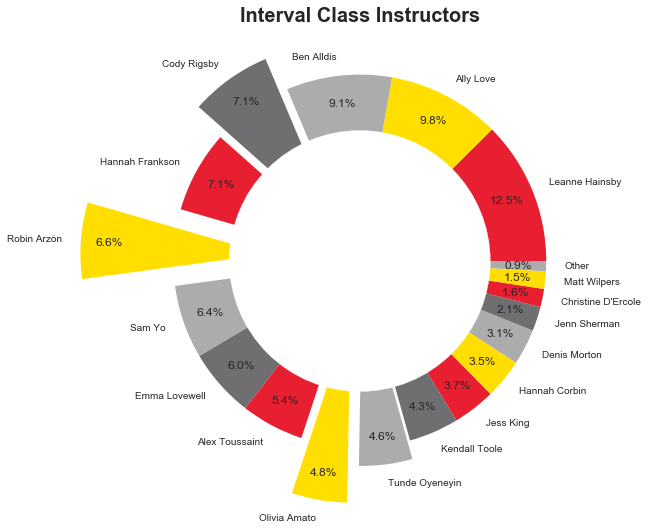

In [359]:
plt.rcParams['font.size'] = 12.0

# Set size
fig = plt.gcf()
fig.set_size_inches(9, 9)


# only "explode" Robin and Olivia as most advanced instructors in Intervals
explode = (0, 0, 0, 0.2, 0,
          0.5, 0, 0, 0, 0.3,  
          0.1, 0, 0, 0, 0,
          0, 0, 0, 0)

#Create pie chart
plt.pie(int_inst, labels = list(int_inst.index), explode=explode,
       labeldistance=1.1, pctdistance=0.85, autopct='%1.1f%%',
        colors = ['#e71f31','#ffde00','#acacad','#6f6f71'])

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle) 

plt.title('Interval Class Instructors', fontsize=20, fontweight="bold")

# Equal aspect ratio ensures that pie is drawn as a circle
# plt.axis('equal')  
plt.tight_layout()
plt.savefig("../../images/Int_Instructors")
plt.show()

### Hannah Corbin<a id="HC"></a>

In [329]:
# Filter down dataset to Hannah Corbin rides
preprocessed[preprocessed['instructorName_Hannah Corbin'] == 1]['classDifficulty_num'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
# Mostly Beginner classes, close with Intermediate though
# Rarely Advanced

0    58.4%
1    39.4%
2     2.2%
Name: classDifficulty_num, dtype: object

#### Learning: 
If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
- If class is > 30 mins... still intermediate
- Is the class an Intervals class? If yes, it will be Advanced
    - Next driver is if instructor is Robin. If yes, then music danceability <= 0.765 (if TRUE, more likely Advanced)
    - If not Robin, then is it Olivia? If yes, then music speechiness <= -0.495 (if FALSE, more likely Advanced)

### Top Artists and Songs in Difficulties

### Beginner Classes (Total Labeled)

In [176]:
# Create data subset of beginner classes for analysis
beg_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 0]

In [177]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
beg_top_artists_all, beg_top_songs_all = diff_top_artists_and_songs(beg_subset_all, df)

In [178]:
# Preview artists 
beg_top_artists_all

# OLD NOTES
# Gavin Degraw - 34%
# Kings of Leon - used more often, but less overall % at 15%
# Dave Matthews
# Maroon 5 and P!nk top class counts - but beginner classes don't make up much of 
# how many overall playlists they show up on

,name,classCount,Class Count,id,class_per,followers,genres,popularity
122,LP,23,40,0J7U24vlOOIeMpuaO6Q85A,0.57,2034354.0,"['la pop', ""women's music""]",73.0
67,Gavin DeGraw,33,76,5DYAABs8rkY9VhwtENoQCz,0.43,1098820.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",68.0
153,Barry White,19,48,3rfgbfpPSfXY40lzRK7Syt,0.40,1257407.0,"['adult standards', 'disco', 'funk', 'motown',...",70.0
77,The Temptations,31,89,3RwQ26hR2tJtA8F9p2n7jG,0.35,2019971.0,"['brill building pop', 'classic soul', 'funk',...",72.0
156,The Fray,19,62,0zOcE3mg9nS6l3yxt1Y0bK,0.31,3287667.0,"['neo mellow', 'piano rock', 'pop', 'pop rock']",74.0
154,Jack Garratt,19,63,1Zp054Jc86WVKCxKEqZGOA,0.30,345251.0,['uk alternative pop'],55.0
167,Matchbox Twenty,19,65,3Ngh2zDBRPEriyxQDAMKd1,0.29,1824581.0,"['neo mellow', 'pop rock', 'post-grunge']",71.0
21,Dave Matthews Band,64,220,2TI7qyDE0QfyOlnbtfDo7L,0.29,1504809.0,"['jam band', 'neo mellow', 'pop rock']",70.0
61,Jackson 5,35,123,2iE18Oxc8YSumAU232n4rW,0.28,NaN,NaN,NaN
99,Wind & Fire,28,105,NaN,0.27,NaN,NaN,NaN


In [179]:
# Preview songs
beg_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
135,Cop Stop,8,spotify:track:2PZo1LXlOMAYGwr0pYn4mT,8,1.00,Gavin DeGraw,NaN,28,204226,False,2008-05-06,0.594,0.7600,7,-5.508,1,0.0306,0.020000,0,0.0816,0.8410,129.938,4
194,Worry,7,spotify:track:2UingDwvZlskY59ehcc2iE,8,0.88,NaN,['Bill Anderson'],0,126707,0,2011-06-13,0.366,0.1830,8,-14.947,1,0.0319,0.864000,0,0.0888,0.5720,89.287,4
239,I'm Not A Saint,6,spotify:track:0CKPLoYW0nsAnjnr00HRWV,7,0.86,Billy Raffoul,NaN,50,195166,True,2018-06-22,0.748,0.7580,10,-5.820,0,0.0726,0.096100,0.000161,0.2120,0.6720,127.979,4
255,In the Summertime,6,spotify:track:22dGwFDrsk4JmMvpY9kkzV,8,0.75,NaN,['Bill Anderson'],0,100480,0,2011-06-13,0.636,0.5090,5,-12.830,1,0.0333,0.253000,0,0.2530,0.9630,123.779,3
228,Crystals,6,spotify:track:5wU6jk9kxYzFGUpeE6T2Q5,8,0.75,NaN,['Of Monsters and Men'],63,243520,0,2015-06-05,0.581,0.7470,0,-7.207,1,0.0303,0.002020,0.000449,0.1090,0.3250,132.195,4
125,Work It Out (Album Version) (feat. Dave Matthe...,8,None,11,0.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Jackie and Wilson (Album Version),15,spotify:track:7mxNte0lD8HOLwLS4TvmdZ,21,0.71,The Karaoke Party Poppers,NaN,0,177863,False,2015-04-15,0.609,0.8820,5,-12.306,1,0.0570,0.103000,0.17,0.0961,0.7550,183.194,4
244,White Houses,6,spotify:track:6UtKnVSvYhNGO0n8SWdpVn,9,0.67,NaN,['Eric Burdon & the Animals'],19,226613,0,1968-08-01,0.565,0.5720,2,-9.818,1,0.0344,0.729000,0.000601,0.3530,0.6220,81.094,4
242,Skeletons,6,spotify:track:3w2kXOCa1Kain0vJTnGknC,10,0.60,NaN,['Stevie Wonder'],37,324507,0,1987-11-06,0.822,0.3410,1,-16.603,1,0.0417,0.004870,0.00031,0.0547,0.6960,99.837,4
66,This Too Shall Pass,10,spotify:track:3l9eeEd5NABrvYRzXIVqwK,17,0.59,OK Go,NaN,46,188120,False,2010-01-12,0.430,0.6610,5,-3.430,1,0.0434,0.000053,0.0063,0.1350,0.3860,160.032,4


### Beginner Classes (Model Results - Low Impact Classes)

In [180]:
# Create data subset of beginner classes for analysis
beg_subset_lowim = preprocessed[(preprocessed['classCategory_Low Impact'] == 1)]

In [181]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
beg_top_artists_lowim, beg_top_songs_lowim = diff_top_artists_and_songs(beg_subset_lowim, df)

In [182]:
# Preview artists 
beg_top_artists_lowim

# OLD NOTES
# Gavin Degraw - 34%
# Kings of Leon - used more often, but less overall % at 15%
# Dave Matthews
# Maroon 5 and P!nk top class counts - but beginner classes don't make up much of 
# how many overall playlists they show up on

,name,classCount,Class Count,id,class_per,followers,genres,popularity
10,Gavin DeGraw,26,76,5DYAABs8rkY9VhwtENoQCz,0.34,1098820.0,"['acoustic pop', 'neo mellow', 'pop', 'pop rock']",68.0
28,The Fray,18,62,0zOcE3mg9nS6l3yxt1Y0bK,0.29,3287667.0,"['neo mellow', 'piano rock', 'pop', 'pop rock']",74.0
64,Gin Blossoms,12,45,6kXp61QMZFPcKMcRPqoiVj,0.27,456493.0,"['alternative rock', 'neo mellow', 'permanent ...",60.0
49,Andy Grammer,14,51,2oX42qP5ineK3hrhBECLmj,0.27,930554.0,"['dance pop', 'modern rock', 'neo mellow', 'po...",77.0
55,Barry White,12,48,3rfgbfpPSfXY40lzRK7Syt,0.25,1257407.0,"['adult standards', 'disco', 'funk', 'motown',...",70.0
71,George Ezra,11,53,2ysnwxxNtSgbb9t1m2Ur4j,0.21,3421047.0,"['folk-pop', 'modern rock', 'neo mellow', 'neo...",76.0
17,Jackson 5,23,123,2iE18Oxc8YSumAU232n4rW,0.19,NaN,NaN,NaN
34,The Temptations,17,89,3RwQ26hR2tJtA8F9p2n7jG,0.19,2019971.0,"['brill building pop', 'classic soul', 'funk',...",72.0
53,Ray LaMontagne,13,68,6DoH7ywD5BcQvjloe9OcIj,0.19,846154.0,"['acoustic pop', 'indie folk', 'neo mellow', '...",69.0
18,Train,23,122,3FUY2gzHeIiaesXtOAdB7A,0.19,3650908.0,"['dance pop', 'neo mellow', 'pop', 'pop rock',...",78.0


In [183]:
# Preview songs
beg_top_songs_lowim

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
17,Cop Stop,8,spotify:track:2PZo1LXlOMAYGwr0pYn4mT,8,1.00,Gavin DeGraw,NaN,28,204226,False,2008-05-06,0.594,0.760,7,-5.508,1,0.0306,0.020000,0,0.0816,0.841,129.938,4
62,Hysteric,5,spotify:track:3zH9RnVnw2v4TemWU5j6Qz,5,1.00,Yeah Yeah Yeahs,NaN,36,230346,False,2009-03-06,0.573,0.674,10,-6.537,1,0.0277,0.000228,0.169,0.1030,0.385,132.036,4
77,Are You Happy Now?,5,spotify:track:5B7XIcS5T76NJZFOHX30Io,6,0.83,NaN,['Michelle Branch'],51,230760,0,2003-06-24,0.484,0.827,8,-5.324,1,0.0460,0.003900,0.00143,0.0876,0.717,179.566,4
66,Soldier,5,spotify:track:5QD28FqaM3jTfsqWwvRZwv,7,0.71,NaN,['Eminem'],63,226213,1,2002-05-26,0.851,0.920,8,-2.989,1,0.2010,0.031900,0.000525,0.1280,0.545,94.516,4
46,I'm Not A Saint,5,spotify:track:0CKPLoYW0nsAnjnr00HRWV,7,0.71,Billy Raffoul,NaN,50,195166,True,2018-06-22,0.748,0.758,10,-5.820,0,0.0726,0.096100,0.000161,0.2120,0.672,127.979,4
53,I'm Good.,5,None,7,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Jackie and Wilson (Album Version),12,spotify:track:7mxNte0lD8HOLwLS4TvmdZ,21,0.57,The Karaoke Party Poppers,NaN,0,177863,False,2015-04-15,0.609,0.882,5,-12.306,1,0.0570,0.103000,0.17,0.0961,0.755,183.194,4
49,White Houses,5,spotify:track:6UtKnVSvYhNGO0n8SWdpVn,9,0.56,NaN,['Eric Burdon & the Animals'],19,226613,0,1968-08-01,0.565,0.572,2,-9.818,1,0.0344,0.729000,0.000601,0.3530,0.622,81.094,4
4,You Are the Best Thing,12,spotify:track:1jyddn36UN4tVsJGtaJfem,26,0.46,NaN,['Ray LaMontagne'],70,231840,0,2008-10-13,0.578,0.727,10,-4.872,1,0.0332,0.030400,1.99e-05,0.1720,0.885,170.593,4
60,Rain (feat. Nicky Jam),5,spotify:track:5od0xFdCUrt6vHz6ejEfwn,11,0.45,The Script,NaN,30,209088,True,2017-10-12,0.679,0.668,6,-7.163,1,0.0737,0.266000,0,0.3540,0.731,92.933,4


### Advanced Classes (Total Labeled)

In [184]:
adv_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 2]

In [185]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
adv_top_artists_all, adv_top_songs_all = diff_top_artists_and_songs(adv_subset_all, df)

In [186]:
adv_top_artists_all

,name,classCount,Class Count,id,class_per,followers,genres,popularity
184,Yelawolf,30,54,68DWke2VjdDmA75aJX5C57,0.56,1685398.0,"['alabama rap', 'hip hop', 'pop rap', 'rap', '...",72.0
186,Knife Party,30,59,2DuJi13MWHjRHrqRUwk8vH,0.51,858221.0,"['australian dance', 'brostep', 'complextro', ...",61.0
81,Ace Hood,54,118,31HjiqargV4NAw4GZqUale,0.46,1371482.0,"['dirty south rap', 'gangster rap', 'hip hop',...",67.0
72,Rage Against The Machine,60,135,2d0hyoQ5ynDBnkvAbJKORj,0.44,4176893.0,"['alternative metal', 'alternative rock', 'con...",75.0
112,Nine Inch Nails,43,99,0X380XXQSNBYuleKzav5UO,0.43,1766783.0,"['alternative metal', 'alternative rock', 'cyb...",69.0
109,Darude,44,104,0LhHRmSd1EYM5QdNeNnCoQ,0.42,133345.0,"['eurodance', 'europop', 'finnish edm']",62.0
130,Twista,40,98,6vbY3hOaCAhC7VjucswgdS,0.41,699514.0,"['chicago rap', 'dirty south rap', 'gangster r...",71.0
123,Limp Bizkit,40,101,165ZgPlLkK7bf5bDoFc6Sb,0.40,3931967.0,"['alternative metal', 'funk metal', 'nu metal'...",76.0
157,Flux Pavilion,32,85,7muzHifhMdnfN1xncRLOqk,0.38,674503.0,"['bass trap', 'brostep', 'classic dubstep', 'e...",66.0
108,Tujamo,45,119,26F2Hcdv4iKv9i9vlE5coT,0.38,5.0,[],0.0


In [187]:
adv_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
61,The Longest Yard,16,spotify:track:0Fi5GPyXr7c2vxdw9rJ8xF,16,1.00,Various Artists,NaN,42,266106,True,2005-01-01,0.830,0.864,4,-4.595,1,0.2860,0.121000,0,0.2040,0.7110,125.011,4
32,Football Fanatic,19,spotify:track:4DjkbfhdhfmzKNOUPtv9Js,19,1.00,Music Beyond,NaN,2,81994,False,2018-10-22,0.644,0.572,8,-5.806,1,0.0289,0.008550,0.916,0.5030,0.3480,120.090,4
29,Hustle Hard Remix - Album Version (Edited),20,None,24,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,Let's Go (feat. Yelawolf,17,spotify:track:19xSVTy7c5jBGmHHgVXNbg,22,0.77,Travis Barker,NaN,56,193080,True,2011,0.707,0.906,9,-5.871,1,0.2040,0.124000,0,0.2940,0.5480,150.032,4
57,Busta Rhymes & Lil Jon),17,None,22,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,Murda Something (feat. Waka Flocka Flame),9,spotify:track:4awpwf3TeFWOtLiswRbKfr,12,0.75,A$AP Ferg,NaN,45,199853,True,2013-08-19,0.844,0.824,8,-4.392,1,0.1190,0.241000,0,0.0816,0.3290,135.982,4
51,Twista,17,None,23,0.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,Raise Up (feat. Petey Pablo) [VIP],8,spotify:track:4Y8oWpT44AVDGg5Ytq3OPP,11,0.73,ETC!ETC!,NaN,17,160324,False,2017-01-13,0.489,0.927,1,-4.479,1,0.0758,0.021700,0.0976,0.5910,0.1390,146.994,4
274,WTF (feat. Amber Van Day) [Tujamo Remix],9,spotify:track:31NDAHPCyqEIPKd3kUV6yA,13,0.69,HUGEL,NaN,48,252857,True,2019-02-15,0.742,0.794,11,-3.367,0,0.0428,0.004390,4.11e-05,0.0683,0.5000,126.032,4
237,No Problem,9,spotify:track:0EgigrGFGb4PHaVNb7fgK7,13,0.69,NaN,['Lil Scrappy'],57,214213,1,2009-08-21,0.858,0.731,1,-7.224,1,0.2370,0.053000,0,0.1500,0.1390,85.984,4


### Advanced Classes (Model Results - 30 Min+ Intervals Classes)

In [188]:
adv_subset_int = preprocessed[(preprocessed['classDuration'] > -0.49) &
                          (preprocessed['classCategory_Intervals'] == 1)]

In [189]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
adv_top_artists_int, adv_top_songs_int = diff_top_artists_and_songs(adv_subset_int, df)

In [190]:
# Preview artists
adv_top_artists_int

,name,classCount,Class Count,id,class_per,followers,genres,popularity
151,I See MONSTAS,27,60,3yWCAtesP5BFtJnBbgfv8b,0.45,10439.0,[],45.0
66,Chase & Status,46,121,3jNkaOXasoc7RsxdchvEVq,0.38,564006.0,"['drum and bass', 'liquid funk']",65.0
76,Tujamo,42,119,26F2Hcdv4iKv9i9vlE5coT,0.35,5.0,[],0.0
116,Sub Focus,32,98,0QaSiI5TLA4N7mcsdxShDO,0.33,282216.0,"['drum and bass', 'house', 'liquid funk', 'uk ...",66.0
132,Keys N Krates,29,98,6c1pBXHYjFcGQQNO5MMsdd,0.30,181860.0,"['bass trap', 'edm', 'electronic trap', 'livet...",57.0
17,John Newman,80,267,34v5MVKeQnIo0CWYMbbrPf,0.30,638402.0,[],71.0
152,Otto Knows,26,90,5fahUm8t5c0GIdeTq0ZaG8,0.29,367948.0,"['edm', 'electro house', 'pop dance', 'progres...",63.0
115,Matthew Koma,32,123,1mU61l2mcjEFraXZLpvVMo,0.26,99247.0,['pop edm'],65.0
71,Jack Ü,44,170,1HxJeLhIuegM3KgvPn8sTa,0.26,1050819.0,"['edm', 'electro house', 'pop dance']",66.0
101,AlunaGeorge,35,134,2VAnyOxzJuSAj7XIuEOT38,0.26,409236.0,"['electropop', 'house', 'pop', 'tropical house']",69.0


In [191]:
# Preview songs
adv_top_songs_int

# OLD NOTES
# Class Count % top songs:
## Champion - Kanye West
## Messiah (Dirty South Remix) - I See MONSTAS 
## Money - ??
## Feel the Love (feat. John Newman) - Rudimental
## Habits (Stay High) (The Chainsmokers Extended) - Tove Lo

# Class Count top songs:
## Habits (Stay High) (The Chainsmokers Extended) - Tove Lo
## Messiah (Dirty South Remix) - I See MONSTAS 
## Levels (Skrillex Remix) - Avicii
## Open Season (Gryffin Remix) - Josef Salvat
## Pompeii (Remix) - Bastille

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
160,Would I Lie To You (Cash Cash Remix),8,spotify:track:5ui8aAJN6W7dvE8hR2OhZS,11,0.73,Various Artists,NaN,39,303070,False,2016-11-11,0.715,0.940,7,-2.232,0,0.0865,0.020500,2.66e-06,0.3800,0.3210,127.007,4
4,Habits (Stay High) (The Chainsmokers Extended ...,19,spotify:track:7lxKUx67JrEoxjayHCb0Xr,28,0.68,Tove Lo,NaN,47,294253,False,2014-03-03,0.684,0.772,10,-5.976,1,0.0356,0.002480,0.00403,0.0894,0.0418,128.025,4
155,Open Wide (feat. Big Sean),8,spotify:track:64j3Bd62HTe0pclk8Aq9BE,12,0.67,NaN,"['Calvin Harris', 'Big Sean']",60,187547,1,2014-10-31,0.760,0.943,1,-2.703,1,0.0363,0.069800,0,0.5250,0.6860,127.976,4
89,Uptown Funk (Will Sparks Remix) (feat. Bruno M...,10,spotify:track:5MpKzeXvOBFiZpQWV9iP5O,15,0.67,Mark Ronson,NaN,59,277226,False,2015-04-13,0.821,0.900,2,-3.258,1,0.1680,0.011400,0.000241,0.8940,0.5460,127.930,4
55,Drop That Low (When I Dip) [Extended Mix],11,None,17,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
217,Shape of You (Galantis Remix),7,spotify:track:5H7CwzYZ60e7w69tX4ivQN,12,0.58,Ed Sheeran,NaN,49,195988,False,2017-02-10,0.838,0.765,1,-2.332,0,0.0462,0.051400,0.00021,0.0297,0.9050,100.021,4
145,Blame (R3HAB Club Remix) (feat. John Newman),8,spotify:track:0ZdJ0MBlyrwvuLNtv3cbKM,14,0.57,Calvin Harris,NaN,30,260666,False,2014-11-10,0.684,0.858,0,-4.001,0,0.1320,0.008970,0,0.3760,0.1640,127.995,4
102,Heads Will Roll (A-Trak Remix),9,spotify:track:2idmlkd8oUaQvYEtINpLBX,16,0.56,Yeah Yeah Yeahs,NaN,60,383546,False,2009,0.744,0.614,1,-3.908,0,0.0838,0.006850,0.334,0.0708,0.7740,131.994,4
1,Messiah (Dirty South Remix),23,spotify:track:4ocOSkLYp68DFrmPuRMvyA,44,0.52,I See MONSTAS,NaN,38,245624,False,2013-01-01,0.553,0.896,0,-5.222,0,0.0429,0.044300,0.333,0.0822,0.3360,128.005,4
100,Plain Jane,9,spotify:track:4dVpf9jZjcORqGTLUaeYj9,18,0.50,NaN,['A$AP Ferg'],77,173600,1,2017-08-18,0.797,0.844,11,-5.482,1,0.2750,0.065100,0,0.0870,0.5200,170.142,4


### Intermediate Classes

In [192]:
inter_subset_all = preprocessed[preprocessed['classDifficulty_num'] == 1]

In [193]:
# run diff_top_artists_and_songs on data set to get top artists and songs for analysis
inter_top_artists_all, inter_top_songs_all = diff_top_artists_and_songs(inter_subset_all, df)

In [194]:
inter_top_artists_all

,name,classCount,Class Count,id,class_per,followers,genres,popularity
238,Take That,38,66,1XgFuvRd7r5g0h844A5ZUQ,0.58,979482.0,"['boy band', 'dance pop', 'europop']",68.0
229,Whitesnake,39,67,3UbyYnvNIT5DFXU4WgiGpP,0.58,1963119.0,"['album rock', 'british blues', 'classic rock'...",69.0
253,Foreigner,36,66,6IRouO5mvvfcyxtPDKMYFN,0.55,1948134.0,"['album rock', 'classic rock', 'hard rock', 'h...",73.0
47,Little Mix,114,226,3e7awlrlDSwF3iM0WBjGMp,0.50,8958639.0,"['dance pop', 'girl group', 'pop', 'post-teen ...",84.0
112,Bryan Adams,64,129,3Z02hBLubJxuFJfhacLSDc,0.50,2068570.0,"['album rock', 'canadian pop', 'canadian singe...",79.0
48,Backstreet Boys,113,229,5rSXSAkZ67PYJSvpUpkOr7,0.49,3795212.0,"['boy band', 'dance pop']",79.0
213,Toto,40,82,2nbTrndWzGHdI3jDqCmTrj,0.49,1562.0,[],28.0
137,The Who,54,113,67ea9eGLXYMsO2eYQRui3w,0.48,3907800.0,"['album rock', 'art rock', 'blues rock', 'brit...",74.0
165,Fifth Harmony,47,97,1l8Fu6IkuTP0U5QetQJ5Xt,0.48,12505767.0,"['dance pop', 'electropop', 'girl group', 'pop...",75.0
176,Stormzy,45,98,2SrSdSvpminqmStGELCSNd,0.46,2232326.0,"['grime', 'uk hip hop']",78.0


In [195]:
inter_top_songs_all

,peloton_song_name,classCount,song_id,Class Count,class_per,artist,artists,popularity,duration_ms,explicit,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
172,Black Magic,16,spotify:track:4cJhBmeJ7KiBeuy7oxRnZ3,17,0.94,NaN,['Slayer'],54,243360,0,1983,0.148,0.908,9,-7.336,1,0.1170,0.000005,0.614,0.0723,0.0707,93.888,4
384,La Isla Bonita,11,spotify:track:6r8k1vznHrzlEKYxL4dZEe,13,0.85,NaN,['Madonna'],72,242320,0,1986-06-30,0.725,0.612,1,-10.706,0,0.0372,0.302000,1.63e-05,0.0548,0.9650,99.978,4
475,There You Go,10,spotify:track:3A3kg1SK2gpHNPZJmXpfTv,12,0.83,NaN,['Johnny Cash'],28,135737,0,1958-11-13,0.778,0.727,10,-11.815,1,0.0542,0.827000,0.0179,0.1410,0.9300,97.884,4
442,Eternal Flame,11,spotify:track:5g3ZD7PmrEQlQZKDW91yGG,14,0.79,NaN,['The Bangles'],64,235667,0,1988-07-17,0.521,0.233,7,-13.683,1,0.0254,0.640000,0,0.2450,0.4090,78.927,3
374,"Knock on Wood (7"" Edit)",11,spotify:track:7vMRj40Rw8PPgZiDcbyUdj,14,0.79,Amii Stewart,NaN,46,227733,False,2016-11-18,0.691,0.873,2,-6.349,1,0.1840,0.000457,0.000582,0.1180,0.6670,139.384,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Heartbeat,14,spotify:track:6iQz54AGEoITB0wgFi3zfz,89,0.16,NaN,['Wham!'],43,283667,0,1984-10-23,0.546,0.552,2,-12.265,1,0.0276,0.160000,0,0.1690,0.8220,134.806,4
138,Hallelujah,18,spotify:track:1IvHVfTXdkwsF9mYNn5nNg,111,0.16,NaN,['Hubert Fol'],0,322133,0,1947,0.519,0.718,8,-12.337,1,0.0406,0.808000,0.0615,0.1950,0.8380,146.555,4
248,Closer,14,spotify:track:5mc6EyF1OIEOhAkD0Gg9Lc,97,0.14,NaN,['Nine Inch Nails'],61,373307,1,1994-03-08,0.546,0.724,10,-8.639,0,0.0427,0.000273,0.667,0.1330,0.5860,89.991,4
250,Diplo & Labrinth),14,None,107,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
inter_top_artists_all['popularity'].describe()

count    247.000000
mean      77.538462
std       11.906373
min        0.000000
25%       72.000000
50%       79.000000
75%       84.000000
max      100.000000
Name: popularity, dtype: float64

In [197]:
twenty_five = np.nanpercentile(inter_top_artists_all['popularity'], 25)
seventy_five = np.nanpercentile(inter_top_artists_all['popularity'], 75)

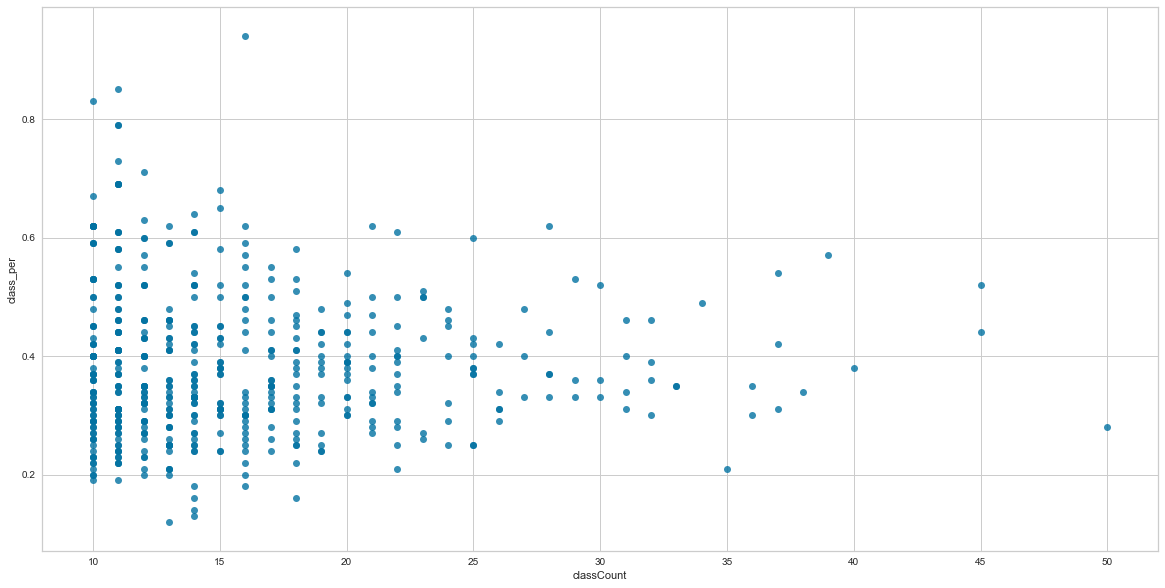

In [198]:
import seaborn as sns

plt.figure(figsize=(20,10))
 
# # use the function regplot to make a scatterplot
# sns.regplot(x=inter_top_songs_all['classCount'], y=inter_top_songs_all['class_per'])
 
# make a scatterplot without regression fit
ax = sns.regplot(x=inter_top_songs_all['classCount'], y=inter_top_songs_all['class_per'], 
                 fit_reg=False)

plt.show()

In [199]:
inter_top_artists_all['artistpop_cat'] = ""

for row in inter_top_artists_all.index:
    if inter_top_artists_all['popularity'][row] < twenty_five:
        inter_top_artists_all['artistpop_cat'][row] = 'Low'
    if inter_top_artists_all['popularity'][row] >= twenty_five and inter_top_artists_all['popularity'][row] < seventy_five:
        inter_top_artists_all['artistpop_cat'][row] = 'Medium'
    if inter_top_artists_all['popularity'][row] >= seventy_five:
        inter_top_artists_all['artistpop_cat'][row] = 'High'

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [200]:
inter_top_artists_all['artistpop_cat'].value_counts()

Medium    127
High       65
Low        55
           11
Name: artistpop_cat, dtype: int64

In [201]:
def plot_scatter(data, x, y, hue, legend, artist_or_song, subset_title):
    plt.figure(figsize=(20,10))
 
    sns.scatterplot(data= data, x= x, y= y, hue= hue, legend= legend)


    plt.title((f'{artist_or_song} Class Count vs Class Percentage in {subset_title}'), fontsize=20, fontweight="bold")
    plt.xlabel((f'{artist_or_song} Class Count'), fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel((f'{artist_or_song} Class Percentage'), fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

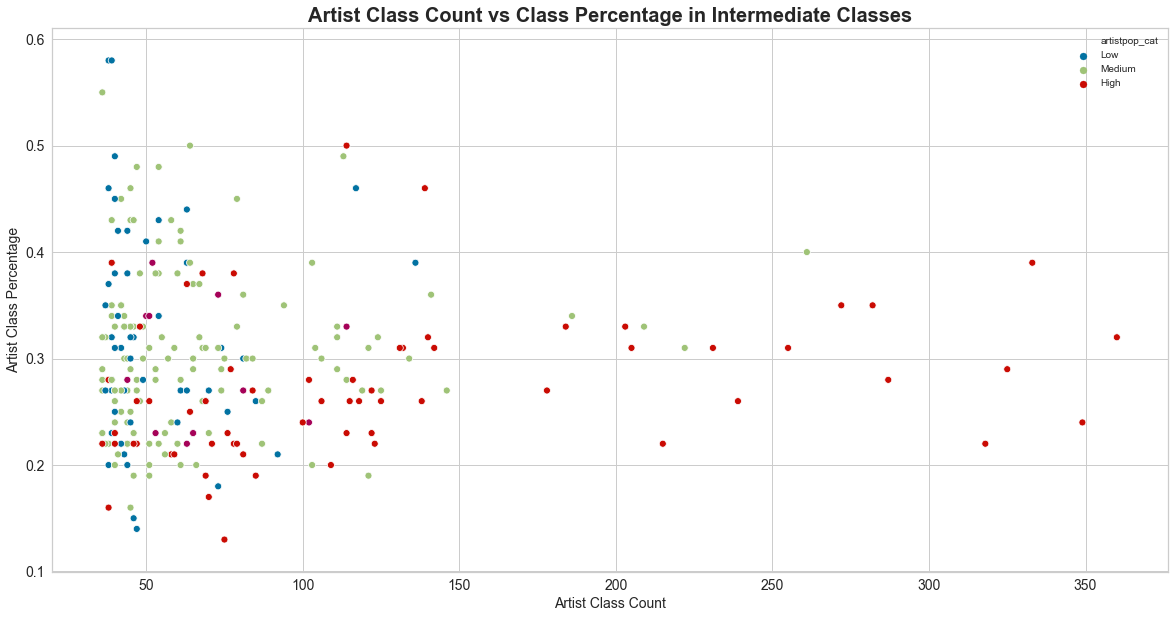

In [202]:
plot_scatter(inter_top_artists_all, x="classCount", y="class_per", 
             hue='artistpop_cat', legend='brief',
             artist_or_song='Artist', subset_title='Intermediate Classes')

In [203]:
twenty_five = np.nanpercentile(inter_top_artists_all['followers'], 25)
seventy_five = np.nanpercentile(inter_top_artists_all['followers'], 75)

In [204]:
inter_top_artists_all['followers_cat'] = ""

for row in inter_top_artists_all.index:
    if inter_top_artists_all['followers'][row] < twenty_five:
        inter_top_artists_all['followers_cat'][row] = 'Low'
    if inter_top_artists_all['followers'][row] >= twenty_five and inter_top_artists_all['followers'][row] < seventy_five:
        inter_top_artists_all['followers_cat'][row] = 'Medium'
    if inter_top_artists_all['followers'][row] >= seventy_five:
        inter_top_artists_all['followers_cat'][row] = 'High'

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [205]:
inter_top_artists_all['followers_cat'].value_counts()

Medium    123
High       62
Low        62
           11
Name: followers_cat, dtype: int64

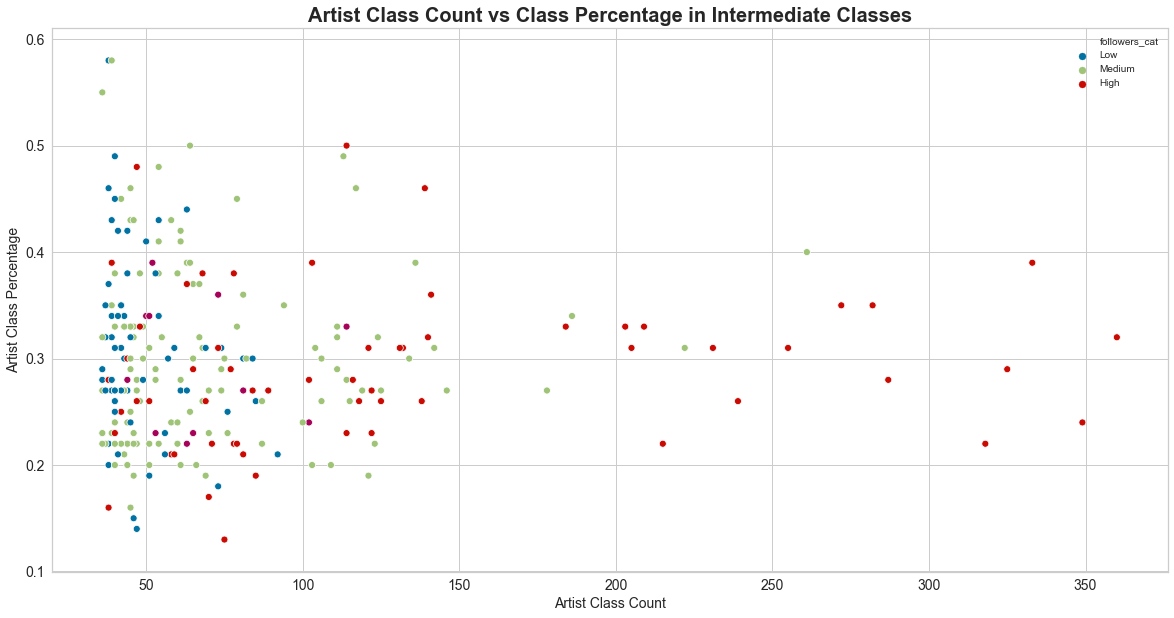

In [207]:
plot_scatter(inter_top_artists_all, x="classCount", y="class_per", 
             hue='followers_cat', legend='brief',
             artist_or_song='Artist', subset_title='Intermediate Classes')

## Data Analysis Learnings <a id="DAL"></a>

#### Learnings from tree and analysis above
1. If class is Low Impact, it is Beginner.


2. If a class is Intervals, difficulty will depend on the duration, instructor and/or the music.


3. If the class is < 30 mins it will more likely be Beginner/Intermediate, but could be Intermediate or Advanced if high danceability (> 1.811) and a Robin class. 
    - Next layer towards Beginner class is if Christine is teaching a non-Intervals class < 30 mins. 
        - Her playlists are more instrumental, so the decision below her is instrumentalness <=5.184. If true, Beginner.



4. If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
    - If class is > 30 mins, then still intermediate
    - Is the class an Intervals class? If yes, it will be Advanced
        - Next driver is if instructor is Robin? If yes, then next driver is it the instructor is Olivia? Then Cody, then Tunde. 
        - If not Robin, music danceability <= 0.765 (if TRUE, more likely Advanced -- but Advanced either way)
    - If class is not Intervals, then if classCategory is Music, the class difficulty will lean Intermediate (rare that these classes are Advanced)

## Conclusion

### Recommendations On Model Utilization:<a id="REC"></a>

In my initial search for class or instructor recommendations for first time riders, I found that there was a lack of information available. There were “top lists” of instructors with general recommendations, but all of them were different. This leads me to believe these are completely based on the publication and the writer's opinions. **There was a lack of any data backed recommendations; thus I confirmed there is an opportunity in the market for a model like this to be implemented.**

As this is an early iteration, this model could be made available using a simple service like Streamlit to test user engagement and satisfaction.

### Future Work<a id="FW"></a>

#### Updated Peloton Class Data Ongoing via API
This model was created utilizing Peloton data from March 2021. As Peloton refreshes their classes a regular basis, it would be a priority to utilize the Peloton API in supporting this model ongoing. The evolution of the library may also bring revisitation to the model as the make up and audience of Peloton also evolves.

#### Peloton Playlist Data Formatting and Accuracy
There is also opportunity in how the Peloton data is formatted, which impacts the gathering of artist and track related data. In the Peloton class data, the song and artist list for a single class’ playlist is separate, which made it difficult to find the exact song. Zipping the two features together did not work as multiple artists can be listed for the same song (see song: “California Girls” artist: Katy Perry, Snoop Dogg). I made the assumption that popular songs users would recognize would be used on playlists; thus searching for the song title on Spotify will return the correct song data. This same assumption applies to searching and obtaining the artist level features. The next iteration should have songs paired with their artists for the most accuracy Spotify search results.

#### Potential Expanded Approach
Prior notebooks outside of the "final notebooks" folder document other paths I considered in creating a base dataset, especially in regards to the music related data. Editing in this approach could potentially impact the feature importance of music and playlist is for various levels of difficulty.

#### Model Improvement and Beta Testing
With each of the above considered, there is exponential opportunity to advance this work and model performance to the point where it can be implemented at Peloton and beta tested with users. As Peloton is very much carried by a positive customer experience overall, the first ride on the bike is a key moment in the users relationship with the brand and fitness overall.